# Import

In [1]:
from geneticalgs import BinaryGA, RealGA, DiffusionGA, MigrationGA

import numpy as np
import csv
import time
import pickle
import math

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
# Make the graphs a bit prettier, and bigger
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Function definition

In [6]:
# read solution from a file
def read_solution(filename):
    with open(filename, 'r') as sol_file:
        reader = csv.reader(sol_file, delimiter=' ', skipinitialspace=True)
        cost_sol = []
        
        for row in reader:
            cost_sol.append(int(row[2]))
            
        return cost_sol

    
# run genetic algorithm
def run_ga(filename, solution_file, model, generation_num, population_size, 
                  elitism=True, selection='rank', tournament_size=None,
                  mut_type=1, mut_prob=0.05, cross_type=1, cross_prob=0.95,
                  print_out=True, mga_period=None, mga_migrant_num=None, mga_cloning=True):
    with open(filename, 'r') as inst_file:
        #################################################
        # read input data and optimal solution from files
        #################################################
        reader = csv.reader(inst_file, delimiter=' ', skipinitialspace=True)
        
        solution_list = read_solution(solution_file)

        dupl_counter = 1
        dupl_counter_delta = 0.00001
        for row, solution in zip(reader, solution_list):
            n = int(row[1])
            M = int(row[2])

            pairs = {}
            for i in range(0, n*2 - 1, 2):
                if int(row[i + 3]) in pairs.keys():
                    # duplication found!
                    if print_out:
                        print(10*'-', 'File:', filename, 'row:', row[0], 'There is a duplicate key!', 10*'-')
                    
                    new_key = int(row[i + 3]) + dupl_counter*dupl_counter_delta
                    
                    dupl_counter += 1
                else:
                    new_key = int(row[i + 3])
                    
                # pair: weight -> cost
                pairs[new_key] = int(row[i + 4])
            
            #################################################
            # define fitness function
            #################################################
            def fitness_func(bin_list, keys):
                """
                Computes relative error of the specified individual.
                """
                cost = 0

                for idx in bin_list:
                    cost += pairs[keys[idx]]
                    
                if selection == 'roulette':
                    # we need to modify rel.error (fitness) in case of minimization, 
                    # because 'roulette' type has more chances to select individual 
                    # with higher rel. error 
                    return 1 - abs((solution - cost) / solution)
                else:
                    return abs((solution - cost) / solution)
            
            #################################################
            # run GA
            #################################################
            if selection == 'roulette':
                optim = 'max'
            else:
                optim = 'min'
                
            input_data = pairs.keys()
            
            if model == 'sga' or model == 'dga':
                # run standard or diffusion genetic algorithm
                ga = BinaryGA(list(input_data), fitness_func, optim=optim, 
                                       elitism=elitism, selection=selection, 
                                       mut_type=mut_type, mut_prob=mut_prob,
                                       cross_type=cross_type, cross_prob=cross_prob,
                                       tournament_size=tournament_size)
                
                if model == 'dga':
                    ga = DiffusionGA(ga)
                    
                ga.init_random_population(population_size)
                
                fitness_progress = ga.run(generation_num)
                best_solution = ga.best_solution
            elif model == 'mga':            
                # run migration genetic algorithm
                # you can initialize instances with DIFFERENT parameters
                ga1 = BinaryGA(list(input_data), fitness_func, optim=optim, 
                                       elitism=elitism, selection=selection, 
                                       mut_type=mut_type, mut_prob=mut_prob,
                                       cross_type=cross_type, cross_prob=cross_prob)
                
                ga2 = BinaryGA(list(input_data), fitness_func, optim=optim, 
                                       elitism=elitism, selection=selection, 
                                       mut_type=mut_type, mut_prob=mut_prob,
                                       cross_type=cross_type, cross_prob=cross_prob)
                
                one_part = population_size // 2
                ga1.init_random_population(one_part)
                ga2.init_random_population(population_size - one_part)
            

                mga = MigrationGA()
                mga.init_populations([ga1, ga2])

                fitness_progress, best_solution = mga.run(generation_num, 
                                                          period=mga_period, # 5
                                                          migrant_num=mga_migrant_num, # 3
                                                          cloning=mga_cloning) # True
            
            print('binary encoded input:', input_data)
            print('best found individual:', best_solution[0])
            print('its fitness value:', best_solution[1])
            
            break  # we want to test only one instance
            
    return fitness_progress

# Run the selected genetic algorithm

## GA on binary encoded input data

This kind of genetic algorithm attempts to find the best combination of an input data. The result is a pair of the best individual (binary encoded input data where 1 means that an item is presented and 0 that is not) and its fitness value.

A genetic algorithm will be performed on [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem). It is easy to apply the current implementation of GA on the any combinatorial optimization problem (for example, *feature selection*). The only changes to be made is a definition of the appropriate *fitness function* and input data (list of features).

### Settings of genetic algorithm

In [3]:
# available instances (number of items): 20 and 40
n = 20

file_inst_template = './data/inst/knap_{}.inst.dat'
file_sol_template = './data/sol/knap_{}.sol.dat'

# GA standard settings
generation_num = 50
population_size = 500
elitism = True
selection = 'rank'
tournament_size = None # in case of tournament selection
mut_type = 1
mut_prob = 0.05
cross_type = 1
cross_prob = 0.95

# Migration GA settings
period = 5
migrant_num = 3
cloning = True

### Run GA

In [7]:
# standard GA
result_sga = list(run_ga(file_inst_template.format(n),
                         file_sol_template.format(n),
                         'sga',
                         generation_num,
                         population_size,
                         selection=selection, 
                         elitism=elitism, 
                         tournament_size=tournament_size, 
                         mut_type=mut_type, 
                         mut_prob=mut_prob, 
                         cross_type=cross_type, 
                         cross_prob=cross_prob, 
                         mga_period=period,
                         mga_migrant_num=migrant_num,
                         mga_cloning=cloning
                         ))

binary encoded input: dict_keys([1, 2, 3, 4, 6, 7, 40, 41, 48, 43, 8, 15, 16, 49, 18, 19, 21, 22, 26, 27])
best found individual: [0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18]
its fitness value: 0.0


In [13]:
# diffusion GA
result_dga = list(run_ga(file_inst_template.format(n),
                         file_sol_template.format(n),
                         'dga',
                         generation_num,
                         population_size,
                         selection=selection, 
                         elitism=elitism, 
                         tournament_size=tournament_size, 
                         mut_type=mut_type, 
                         mut_prob=mut_prob, 
                         cross_type=cross_type, 
                         cross_prob=cross_prob, 
                         mga_period=period,
                         mga_migrant_num=migrant_num,
                         mga_cloning=cloning
                         ))

binary encoded input: dict_keys([1, 2, 3, 4, 6, 7, 40, 41, 48, 43, 8, 15, 16, 49, 18, 19, 21, 22, 26, 27])
best found individual: [0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18]
its fitness value: 0.0


In [14]:
# migration GA: 2 populations
result_mga = list(run_ga(file_inst_template.format(n),
                         file_sol_template.format(n),
                         'mga',
                         generation_num,
                         population_size,
                         selection=selection, 
                         elitism=elitism, 
                         tournament_size=tournament_size, 
                         mut_type=mut_type, 
                         mut_prob=mut_prob, 
                         cross_type=cross_type, 
                         cross_prob=cross_prob, 
                         mga_period=period,
                         mga_migrant_num=migrant_num,
                         mga_cloning=cloning
                         ))

binary encoded input: dict_keys([1, 2, 3, 4, 6, 7, 40, 41, 48, 43, 8, 15, 16, 49, 18, 19, 21, 22, 26, 27])
best found individual: [0, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19]
its fitness value: 0.0


### Plots

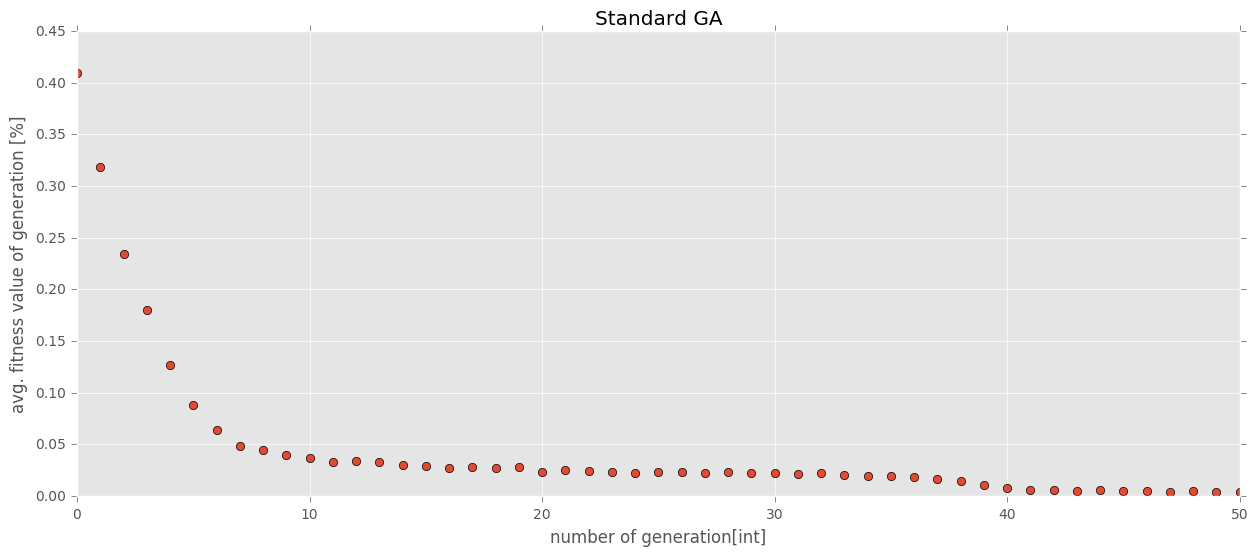

In [15]:
plt.plot(range(len(result_sga)), result_sga, 'o')
plt.xlabel('number of generation[int]')
plt.ylabel('avg. fitness value of generation [%]')
plt.title('Standard GA')

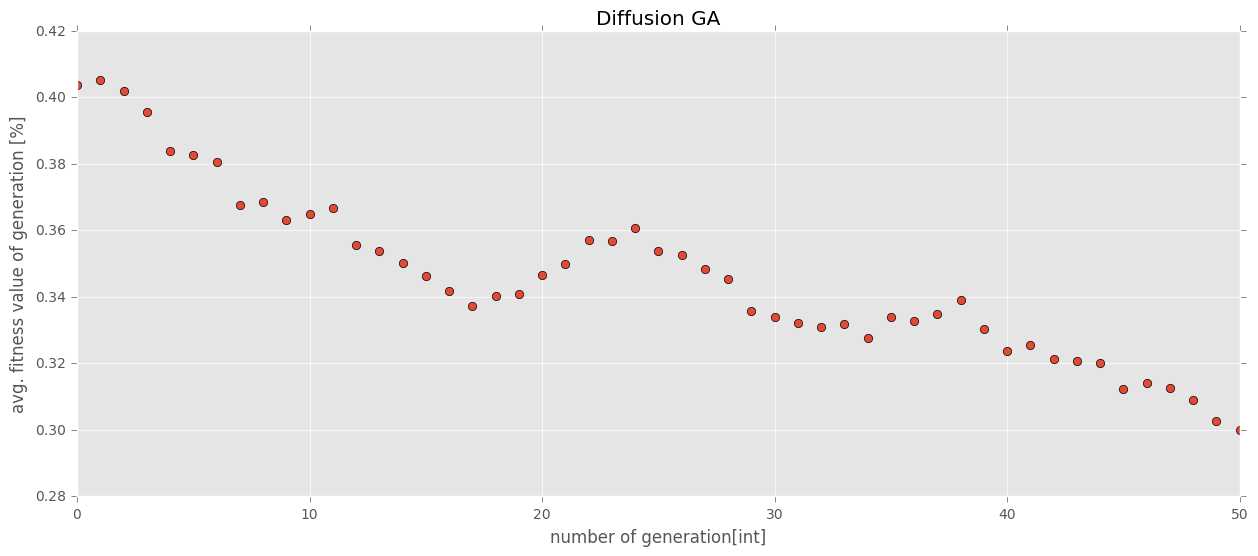

In [16]:
plt.plot(range(len(result_dga)), result_dga, 'o')
plt.xlabel('number of generation[int]')
plt.ylabel('avg. fitness value of generation [%]')
plt.title('Diffusion GA')

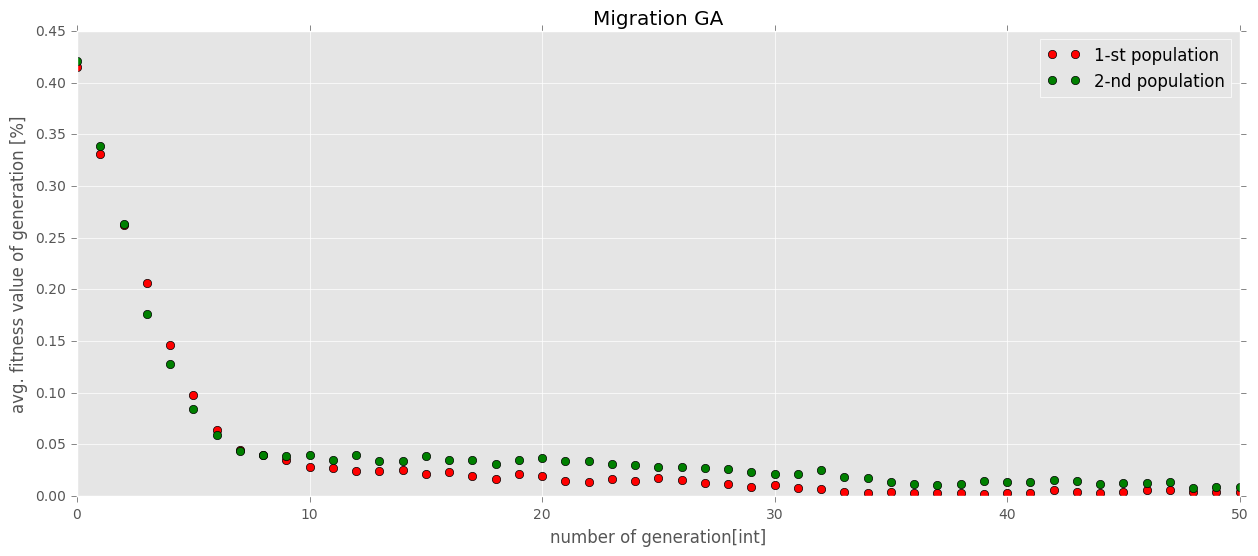

In [17]:
plt.plot(range(len(result_mga[0])), result_mga[0], 'ro', label='1-st population')
plt.plot(range(len(result_mga[1])), result_mga[1], 'go', label='2-nd population')
plt.xlabel('number of generation[int]')
plt.ylabel('avg. fitness value of generation [%]')
plt.legend(loc='best')
plt.title('Migration GA')

## GA on real values

Define function for searching for its minimum or maximum

In [18]:
def func(x):
    return abs(x*(math.sin(x/11)/5 + math.sin(x/110)))

Visualize the function

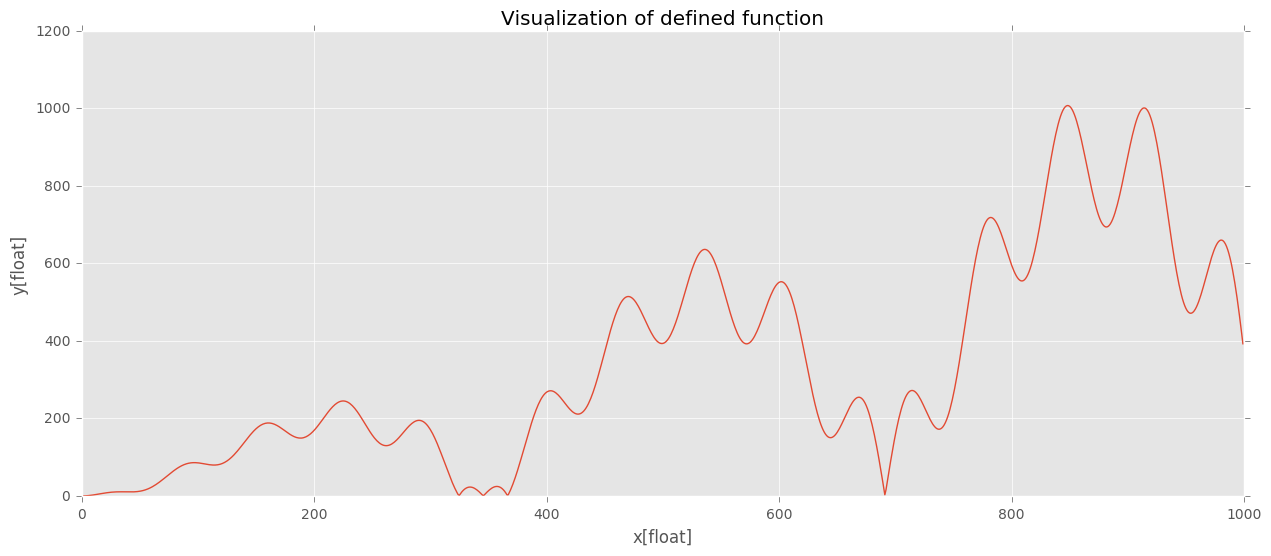

In [19]:
x1 = list(range(1000))
y1 = [func(elem) for elem in x1]

plt.plot(x1, y1, label='defined function')
plt.xlabel('x[float]')
plt.ylabel('y[float]')
plt.title('Visualization of defined function')

### Settings of genetic algorithm

In [20]:
# GA standard settings
generation_num = 50
population_size = 16
elitism = True
selection = 'rank'
tournament_size = None # in case of tournament selection
mut_type = 1
mut_prob = 0.05
cross_type = 1
cross_prob = 0.95
optim = 'min' # minimize or maximize a fitness value? May be 'min' or 'max'.
interval = (0, 1000)

# Migration GA settings
period = 5
migrant_num = 3
cloning = True

#### Standard GA

In [21]:
sga = RealGA(func, optim=optim, elitism=elitism, selection=selection,
            mut_type=mut_type, mut_prob=mut_prob, 
            cross_type=cross_type, cross_prob=cross_prob)

In [22]:
sga.init_random_population(population_size, 1, interval)

##### Plotting samples

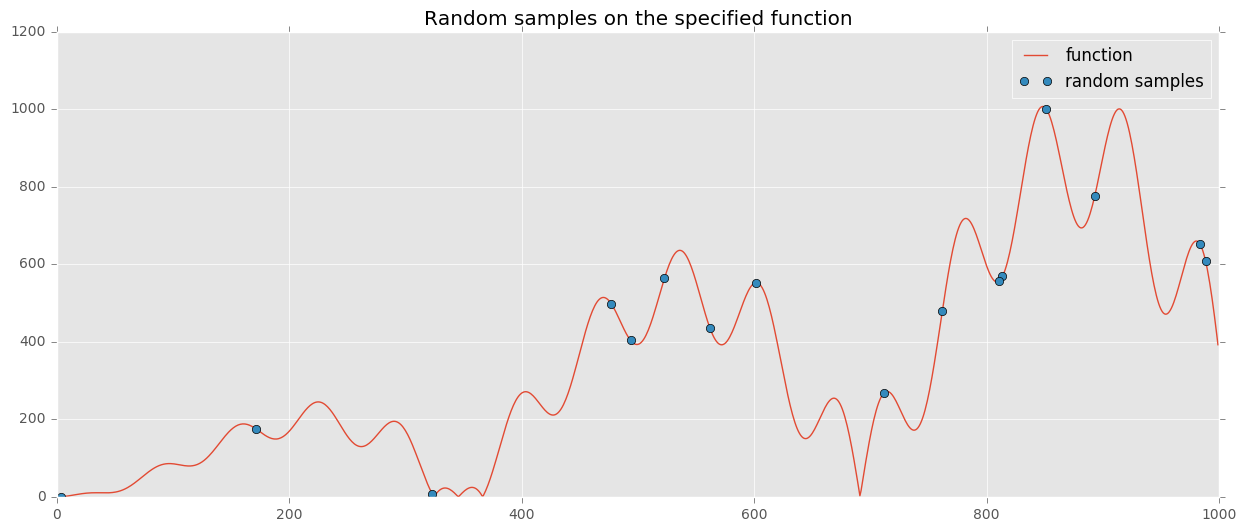

In [26]:
# standard GA
x2 = []
y2 = []
for ind in sga.population:
    x2.append(ind.chromosome)
    y2.append(ind.fitness_val)
    
x1 = list(range(1000))
y1 = [func(elem) for elem in x1]

plt.plot(x1, y1, label='function')
plt.plot(x2, y2, 'o', label='random samples')
plt.legend(loc='best')
plt.title('Random samples on the specified function')

##### Running GA and results

In [27]:
fitness_progress = sga.run(generation_num)
sga.best_solution

(2.0004904439038116, 0.10874198153775787)

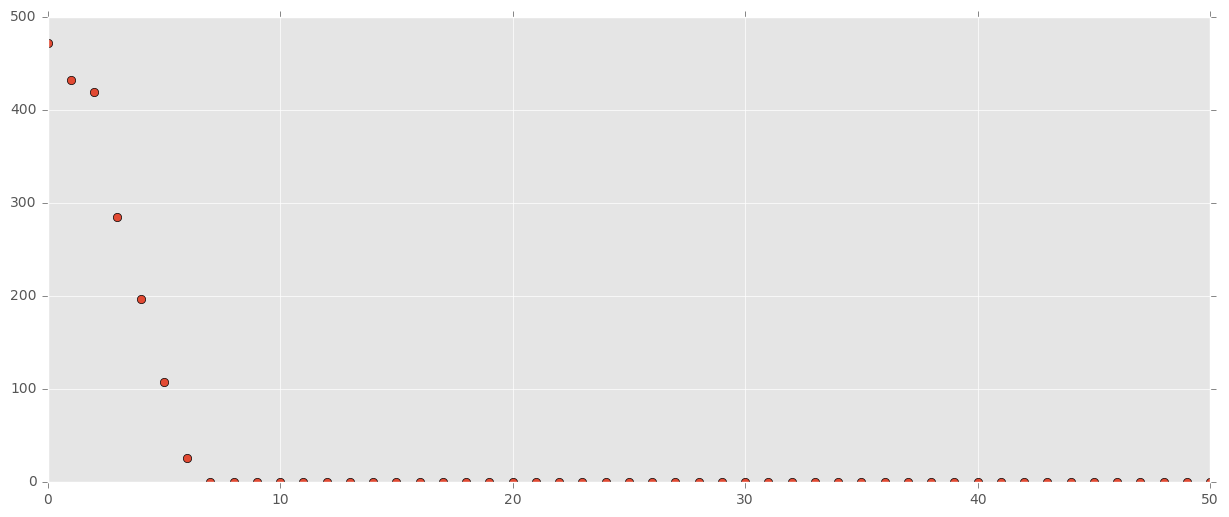

In [28]:
x1 = list(range(len(fitness_progress)))

plt.plot(x1, fitness_progress, 'o')

#### Diffusion GA

In [29]:
dga = RealGA(func, optim=optim, elitism=elitism, selection=selection,
            mut_type=mut_type, mut_prob=mut_prob, 
            cross_type=cross_type, cross_prob=cross_prob)

dga = DiffusionGA(dga)

In [30]:
dga.init_random_population(population_size, 1, interval)

##### Plotting samples

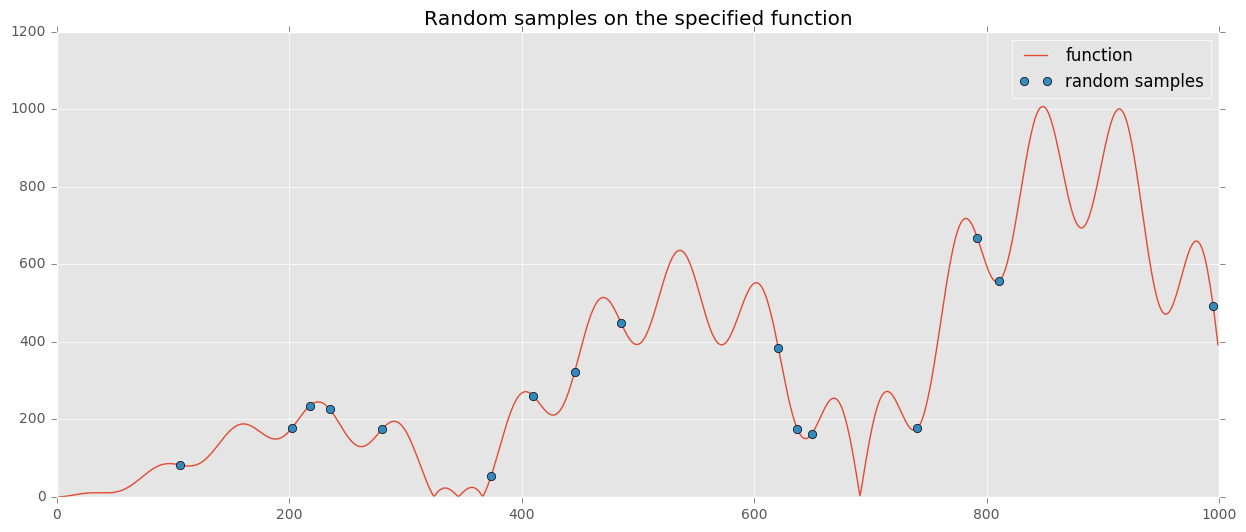

In [31]:
# diffusion GA
individ_arr, fitness_arr = dga.population
x2 = []
y2 = []
for row in range(individ_arr.shape[0]):
    for column in range(individ_arr.shape[1]):
        x2.append(individ_arr[row, column])
        y2.append(fitness_arr[row, column])
    
x1 = list(range(1000))
y1 = [func(elem) for elem in x1]

plt.plot(x1, y1, label='function')
plt.plot(x2, y2, 'o', label='random samples')
plt.legend(loc='best')
plt.title('Random samples on the specified function')

##### Running diffusion GA and results

In [32]:
fitness_progress = dga.run(generation_num)
dga.best_solution

(46.140778811726477, 10.773136702128921)

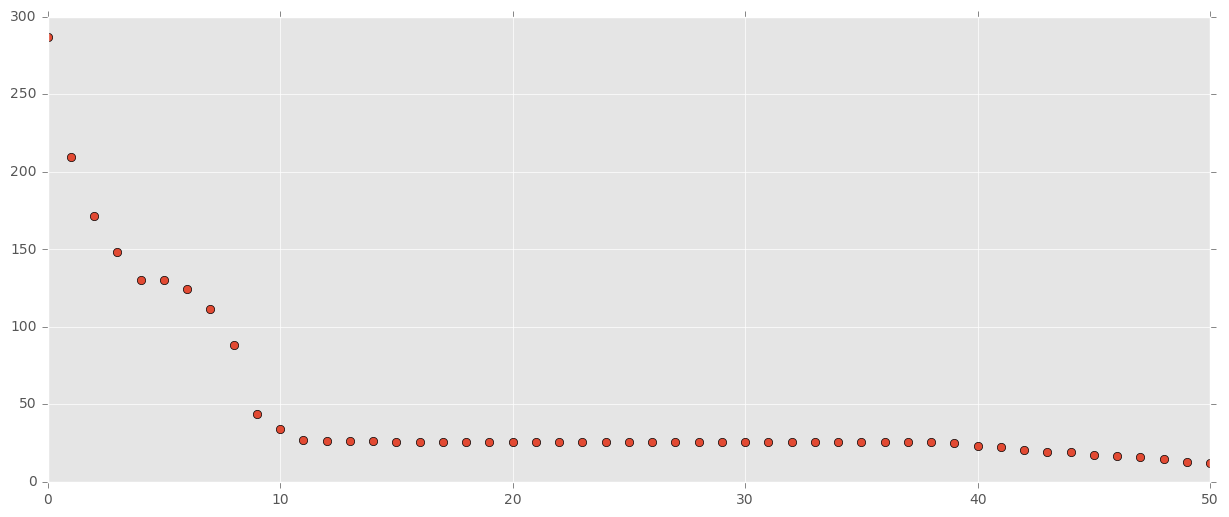

In [33]:
x1 = list(range(len(fitness_progress)))

plt.plot(x1, fitness_progress, 'o')

#### Migration GA

In [41]:
ga1 = RealGA(func, optim=optim, elitism=elitism, selection=selection,
            mut_type=mut_type, mut_prob=mut_prob, 
            cross_type=cross_type, cross_prob=cross_prob)

ga2 = RealGA(func, optim=optim, elitism=elitism, selection=selection,
            mut_type=mut_type, mut_prob=mut_prob, 
            cross_type=cross_type, cross_prob=cross_prob)

In [42]:
one_part = population_size // 2
ga1.init_random_population(one_part, 1, interval)
ga2.init_random_population(population_size - one_part, 1, interval)

In [43]:
mga = MigrationGA()
mga.init_populations([ga1, ga2])

##### Plotting samples

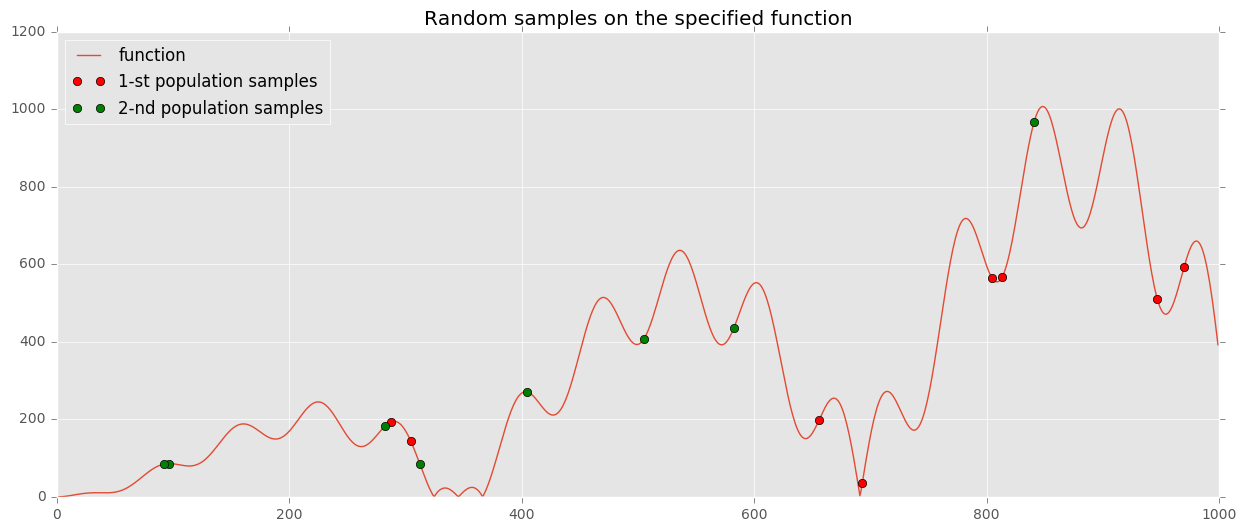

In [44]:
# migration GA
x2 = []
y2 = []
for ind in mga._ga_list[0].population:
    x2.append(ind.chromosome)
    y2.append(ind.fitness_val)
    
x3 = []
y3 = []
for ind in mga._ga_list[1].population:
    x3.append(ind.chromosome)
    y3.append(ind.fitness_val)
    
x1 = list(range(1000))
y1 = [func(elem) for elem in x1]

plt.plot(x1, y1, label='function')
plt.plot(x2, y2, 'ro', label='1-st population samples')
plt.plot(x3, y3, 'go', label='2-nd population samples')
plt.legend(loc='best')
plt.title('Random samples on the specified function')

##### Running GA and results

In [45]:
fitness_progress, best_solution = mga.run(generation_num, 
                                          period=period, 
                                          migrant_num=migrant_num, 
                                          cloning=cloning)

best_solution

(346.00055125590825, 1.3372871749180431)

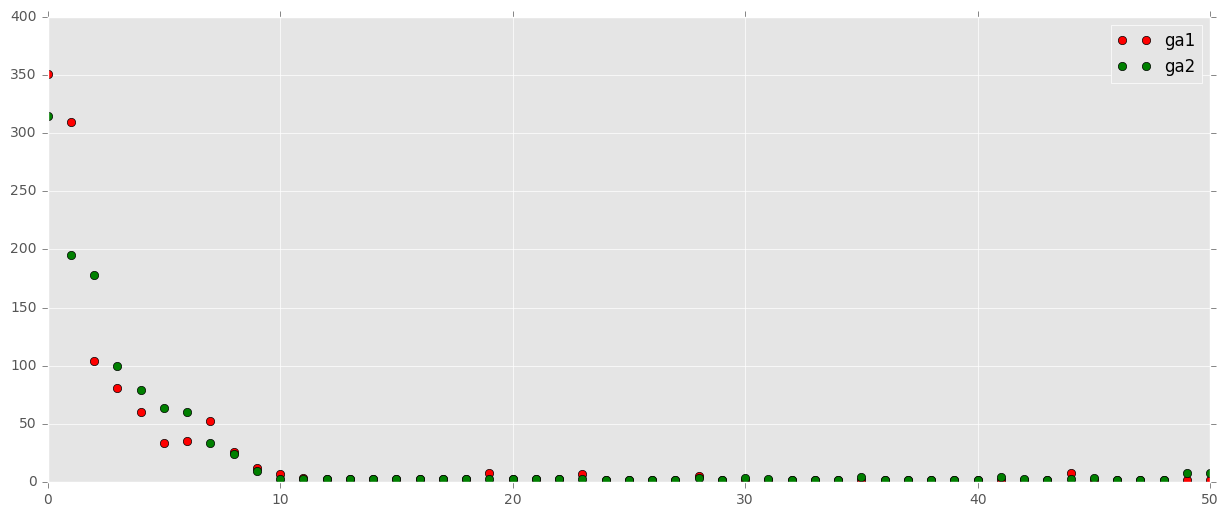

In [46]:
x1 = list(range(len(fitness_progress[0])))

plt.plot(x1, fitness_progress[0], 'ro', label='ga1')
plt.plot(x1, fitness_progress[1], 'go', label='ga2')
plt.legend(loc='best')